In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ### draft_1


# import pandas as pd
# import numpy as np
# import warnings

# from  datetime import datetime, timedelta
# from sklearn.preprocessing import LabelEncoder,MinMaxScaler
# import category_encoders as ce
# import matplotlib.pyplot as plt
# import gc; gc.enable()

# %matplotlib inline
# warnings.filterwarnings('ignore')

# ### 1.2 Read in data

# calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
# sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
# sales_train_val = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')

# ### 1.2.1. Calendar Data Frame

# calendar.info()

# ### Fill NaN values with '0' for Label encoding ( will be useful in 2d notebook)

# calendar = calendar.replace(np.nan,'0')

# ### label encode events

# names = pd.concat([calendar['event_name_1'],calendar['event_name_2']])
# types = pd.concat([calendar['event_type_1'],calendar['event_type_2']])

# le = LabelEncoder()
# names = le.fit_transform(names)
# types = le.fit_transform(types)

# categorical = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
# encoded = [names[:1969], types[:1969], names[1969:], types[1969:]]
# encoded = pd.DataFrame(np.array(encoded).transpose(), columns = categorical)
# del names, types

# # check encoding
# # calendar.loc[(calendar['event_type_1']=='Cultural')|(calendar['event_type_2']=='Cultural')]

# # concat encoded columns back to the calendar df
# calendar.drop(columns = categorical , inplace=True)
# calendar = pd.concat([calendar, encoded],axis=1)
# calendar.head(4).append(calendar.tail(2))

# ### Convert dtype for memory optimization

# calendar['date'] = pd.to_datetime(calendar['date'])
# # calendar.set_index('date', inplace=True)

# # get some features from the date that not in the calendar dataframe 
# calendar['day'] = calendar['date'].dt.day.astype(np.int8)
# calendar['week'] = calendar['date'].dt.week.astype(np.int8)

# # convert d column to numerical
# calendar['d'] = calendar['d'].apply(lambda x: x[2:]).astype(np.int16)

# # prepare list of columns to data reducing

# col_int8 = ['wday','month','snap_TX',
#             'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'] 
# ### !!! Note: Dont forget to add snap_TX, snap_WI for all data

# col_int16 = ['wm_yr_wk','year']
# categ = ['weekday']

# # convert dtypes:

# for i in col_int8:
#     calendar[i] = calendar[i].astype(np.int8)
    
# for i in col_int16:
#     calendar[i] = calendar[i].astype(np.int16)

# for i in categ:
#     calendar[i] = calendar[i].astype('category')

# ### Reduce to day 1941(week #11617) per available train and validation data for PUBLIC LB ONLY!!!!
# calendar = calendar.loc[calendar['d']<=1941]

# calendar.info()

# ### 1.2.2. Sell_prices data frame

# sell_prices.head(3).append(sell_prices.tail(2))

# # Sort by values and reset index
# sell_prices = sell_prices.sort_values(by=['item_id','wm_yr_wk'])
# sell_prices.reset_index(inplace=True)
# del sell_prices["index"]

# sell_prices.head(3).append(sell_prices.tail(2))

# ### Convert dtype for memory optimization

# sell_prices['store_id'] = sell_prices['store_id'].astype('category')
# sell_prices['item_id'] = sell_prices['item_id'].astype('category')
# sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype(np.int16)

# ### Reduce to week #11617( day 1941) per available train and validation data

# sell_prices = sell_prices.loc[sell_prices['wm_yr_wk']<=11617]

# sell_prices.head(2).append(sell_prices.tail(3))

# ### 1.2.3. Sales_train_validation Data Frame

# sales_train_val.head(3).append(sales_train_val.tail(2))

# sales_train_val.info()

# ### Create more data points by changing horizontal orientation of d_1, d_2, ... columns

# used_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# sales_train_val = pd.melt(sales_train_val,
#                           used_columns,
#                           var_name='d',
#                           value_name='sales')

# sales_train_val.head(3).append(sales_train_val.tail(2))

# ### Convert dtype for memory optimization

# ### rename sales_train_val to df_sales
# df_sales = sales_train_val.copy()
# del sales_train_val

# # optimize data
# df_sales['d'] = df_sales['d'].apply(lambda x: x[2:])
# df_sales['d'] = df_sales['d'].astype(np.int16)
# df_sales['sales'] = df_sales['sales'].astype(np.int16)

# for col in used_columns:
#     df_sales[col] = df_sales[col].astype('category')

# df_sales.head(3).append(df_sales.tail(2))

# df_sales.info()

# ### 1.3 Merge in one data frame


# df_sales.head(3).append(df_sales.tail(2))

# calendar.head(3).append(calendar.tail(2))

# sell_prices.head(3).append(sell_prices.tail(2))

# ### 1.3.1. Merge df_sales and calendar data frame

# df_sales = df_sales.merge(calendar,on='d')

# df_sales.head(3).append(df_sales.tail(2))

# df_sales.columns

# ### 1.3.2. Merge df_sales and sell_price data frame

# df_sales = df_sales.merge(sell_prices, on=['store_id','item_id','wm_yr_wk'])

# # rename data frame as df and delete everything else
# df=df_sales.copy()
# del df_sales, sell_prices, calendar

# # create revenue column
# df['revenue'] = df['sales'] * df['sell_price']

# df.head(3).append(df.tail(2))

# df.info()
# gc.collect()

# # df.to_csv('wm_sales.csv',index=False)
# #df.to_pickle('wm_sales.pkl')

In [2]:
## Walmart sale forecat-EDA

### In this notebook, I will explore the data & identify top revenue generators


### 1.1 Import Librries

import pandas as pd
import numpy as np
import warnings
import pickle
import gc; gc.enable()



from  datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import category_encoders as ce
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')


### 1.2 Read in data
### Data Soutce: https://www.kaggle.com/c/m5-forecasting-accuracy/data

# calendar = pd.read_csv('calendar.csv')
# sell_prices = pd.read_csv('sell_prices.csv')
# sales_train_val = pd.read_csv('sales_train_evaluation.csv')
# sales_train_val = pd.read_csv('sales_train_validation.csv') # before 1st June

calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
sales_train_val = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_evaluation.csv')

### 1.2.1. Calendar Data Frame

calendar.head(3).append(calendar.tail(2))

calendar.columns

calendar.info()

### Fill NaN values with '0' for Label encoding ( will be useful in 2d notebook)

calendar = calendar.replace(np.nan,'0')

### label encode events

names = pd.concat([calendar['event_name_1'],calendar['event_name_2']])
types = pd.concat([calendar['event_type_1'],calendar['event_type_2']])

le = LabelEncoder()
names = le.fit_transform(names)
types = le.fit_transform(types)

categorical = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
encoded = [names[:1969], types[:1969], names[1969:], types[1969:]]
encoded = pd.DataFrame(np.array(encoded).transpose(), columns = categorical)
del names, types

# check encoding
# calendar.loc[(calendar['event_type_1']=='Cultural')|(calendar['event_type_2']=='Cultural')]

# concat encoded columns back to the calendar df
calendar.drop(columns = categorical , inplace=True)
calendar = pd.concat([calendar, encoded],axis=1)
calendar.head(4).append(calendar.tail(2))

### Convert dtype for memory optimization

calendar['date'] = pd.to_datetime(calendar['date'])
# calendar.set_index('date', inplace=True)

# get some features from the date that not in the calendar dataframe 
calendar['day'] = calendar['date'].dt.day.astype(np.int8)
calendar['week'] = calendar['date'].dt.week.astype(np.int8)

# convert d column to numerical
calendar['d'] = calendar['d'].apply(lambda x: x[2:]).astype(np.int16)

# prepare list of columns to data reducing

col_int8 = ['wday','month','snap_TX','snap_CA', 'snap_WI',
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'] 
### !!! Note: Dont forget to add snap_TX, snap_WI for all data

col_int16 = ['wm_yr_wk','year']
categ = ['weekday']

# convert dtypes:

for i in col_int8:
    calendar[i] = calendar[i].astype(np.int8)
    
for i in col_int16:
    calendar[i] = calendar[i].astype(np.int16)

for i in categ:
    calendar[i] = calendar[i].astype('category')

### Reduce to week #11613 or day 1913 per available train and validation data
# calendar = calendar.loc[calendar['d']<=1913]

calendar.info()

### 1.2.2. Sell_prices data frame

sell_prices.head(3).append(sell_prices.tail(2))

# Sort by values and reset index
sell_prices = sell_prices.sort_values(by=['item_id','wm_yr_wk'])
sell_prices.reset_index(inplace=True)
del sell_prices["index"]

sell_prices.head(3).append(sell_prices.tail(2))

sell_prices.describe()

sell_prices.info()

### Convert dtype for memory optimization

sell_prices['store_id'] = sell_prices['store_id'].astype('category')
sell_prices['item_id'] = sell_prices['item_id'].astype('category')

sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype(np.int16)
sell_prices['sell_price'] = sell_prices['sell_price'].astype(np.float32)

sell_prices.describe()

sell_prices.info()

### Reduce to week #11613 or day 1913 per available train and validation data

# sell_prices = sell_prices.loc[sell_prices['wm_yr_wk']<=11613]

# sell_prices.head(2).append(sell_prices.tail(3))

### 1.2.3. Sales_train_validation Data Frame

sales_train_val.head(3).append(sales_train_val.tail(2))

sales_train_val.info()

### Create more data points by changing horizontal orientation of d_1, d_2, ... columns

used_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

sales_train_val = pd.melt(sales_train_val,
                          used_columns,
                          var_name='d',
                          value_name='sales')

sales_train_val.head(3).append(sales_train_val.tail(2))

### Convert dtype for memory optimization

### rename sales_train_val to df_sales
df_sales = sales_train_val.copy()
del sales_train_val

df_sales.sales.describe()

df_sales.sales.astype(np.int16).describe()

# optimize data
df_sales['d'] = df_sales['d'].apply(lambda x: x[2:])
df_sales['d'] = df_sales['d'].astype(np.int16)
df_sales['sales'] = df_sales['sales'].astype(np.int16)

for col in used_columns:
    df_sales[col] = df_sales[col].astype('category')

df_sales.head(3).append(df_sales.tail(2))

df_sales.info()

df_sales.describe()

### 1.3 Merge in one data frame


df_sales.head(3).append(df_sales.tail(2))

calendar.head(3).append(calendar.tail(2))

sell_prices.head(3).append(sell_prices.tail(2))

### 1.3.1. Merge df_sales and calendar data frame

df_sales = df_sales.merge(calendar,on='d')

df_sales.head(3).append(df_sales.tail(2))

df_sales.columns

### 1.3.2. Merge df_sales and sell_price data frame

df_sales = df_sales.merge(sell_prices, on=['store_id','item_id','wm_yr_wk'])

# rename data frame as df and delete everything else
df=df_sales.copy()
del df_sales, sell_prices, calendar

# create revenue column
df['revenue'] = df['sales'] * df['sell_price']

df.head(3).append(df.tail(2))

### check for duplicate columns

df[['item_id','date','d','wm_yr_wk','weekday','wday','month','year','day','week']]

del df['weekday']

df.info()

### 1.4. Save df. 
# df.to_csv('wm_sales.csv', index=False)
#df.to_pickle('wm_sales.pkl')

gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------ 

0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46881677 entries, 0 to 46881676
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             int16         
 7   sales         int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  wday          int8          
 11  month         int8          
 12  year          int16         
 13  snap_CA       int8          
 14  snap_TX       int8          
 15  snap_WI       int8          
 16  event_name_1  int8          
 17  event_type_1  int8          
 18  event_name_2  int8          
 19  event_type_2  int8          
 20  day           int8          
 21  week          int8          
 22  sell_price    float32       
 23  revenue       float32       
d

In [4]:
df.head().append(df.tail())

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,day,week,sell_price,revenue
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12,2011-01-29,11101,...,0,0,0,0,0,0,29,4,0.46,5.52
1,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,2,15,2011-01-30,11101,...,0,0,0,0,0,0,30,4,0.46,6.90
2,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,3,0,2011-01-31,11101,...,0,0,0,0,0,0,31,5,0.46,0.00
3,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,4,0,2011-02-01,11101,...,1,0,0,0,0,0,1,5,0.46,0.00
4,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,5,0,2011-02-02,11101,...,0,1,0,0,0,0,2,5,0.46,0.00
46881672,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,2,2016-05-22,11617,...,0,0,0,0,0,0,22,20,3.98,7.96
46881673,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1940,1,2016-05-21,11617,...,0,0,0,0,0,0,21,20,1.28,1.28
46881674,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0,2016-05-22,11617,...,0,0,0,0,0,0,22,20,1.28,0.00
46881675,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1940,5,2016-05-21,11617,...,0,0,0,0,0,0,21,20,1.00,5.00
46881676,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1941,1,2016-05-22,11617,...,0,0,0,0,0,0,22,20,1.00,1.00


In [5]:
import psutil
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    gc.collect()
    return df

In [6]:
reduce_mem_usage(df)

Mem. usage decreased to 2281.79 Mb (0.0% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,day,week,sell_price,revenue
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12,2011-01-29,11101,...,0,0,0,0,0,0,29,4,0.46,5.52
1,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,2,15,2011-01-30,11101,...,0,0,0,0,0,0,30,4,0.46,6.90
2,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,3,0,2011-01-31,11101,...,0,0,0,0,0,0,31,5,0.46,0.00
3,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,4,0,2011-02-01,11101,...,1,0,0,0,0,0,1,5,0.46,0.00
4,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,5,0,2011-02-02,11101,...,0,1,0,0,0,0,2,5,0.46,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46881672,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,2,2016-05-22,11617,...,0,0,0,0,0,0,22,20,3.98,7.96
46881673,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1940,1,2016-05-21,11617,...,0,0,0,0,0,0,21,20,1.28,1.28
46881674,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0,2016-05-22,11617,...,0,0,0,0,0,0,22,20,1.28,0.00
46881675,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1940,5,2016-05-21,11617,...,0,0,0,0,0,0,21,20,1.00,5.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46881677 entries, 0 to 46881676
Data columns (total 24 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             int16         
 7   sales         int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  wday          int8          
 11  month         int8          
 12  year          int16         
 13  snap_CA       int8          
 14  snap_TX       int8          
 15  snap_WI       int8          
 16  event_name_1  int8          
 17  event_type_1  int8          
 18  event_name_2  int8          
 19  event_type_2  int8          
 20  day           int8          
 21  week          int8          
 22  sell_price    float32       
 23  revenue       float32       
d

## Investigate by revenue

In [8]:
df.id.nunique()

30490

In [9]:
last_year = df.loc[df.wm_yr_wk >=(11617-52)]
total_rev = last_year.revenue.sum()

last_year = last_year.groupby(by=last_year['id'])[['revenue','sales']].sum().sort_values(by = 'revenue',ascending=False)
last_year['share']  = (last_year.revenue/total_rev)*100
last_year['cumul_share'] = last_year['share'].cumsum()
last_year.reset_index(inplace=True)

In [10]:
last_year

,id,revenue,sales,share,cumul_share
0,HOBBIES_1_354_TX_3_evaluation,63195.000000,2750,0.412143,0.412143
1,HOBBIES_1_158_TX_3_evaluation,55014.117188,2394,0.358789,0.770933
2,FOODS_1_096_WI_2_evaluation,44252.039062,6119,0.288602,1.059534
3,FOODS_3_120_CA_3_evaluation,31636.939453,6353,0.206329,1.265863
4,HOBBIES_1_354_TX_2_evaluation,28747.980469,1251,0.187488,1.453351
...,...,...,...,...,...
30485,HOUSEHOLD_2_108_TX_3_evaluation,0.000000,0,0.000000,99.999657
30486,HOUSEHOLD_2_108_WI_3_evaluation,0.000000,0,0.000000,99.999657
30487,FOODS_3_369_WI_2_evaluation,0.000000,0,0.000000,99.999657
30488,HOUSEHOLD_2_147_TX_1_evaluation,0.000000,0,0.000000,99.999657


In [11]:
# last_year.loc[last_year.sales<12]
last_year.sales.describe()
# last_year[:100].sales.describe()

count    30490.000000
mean       159.628075
std        336.464317
min          0.000000
25%         31.000000
50%         71.000000
75%        160.000000
max      12818.000000
Name: sales, dtype: float64

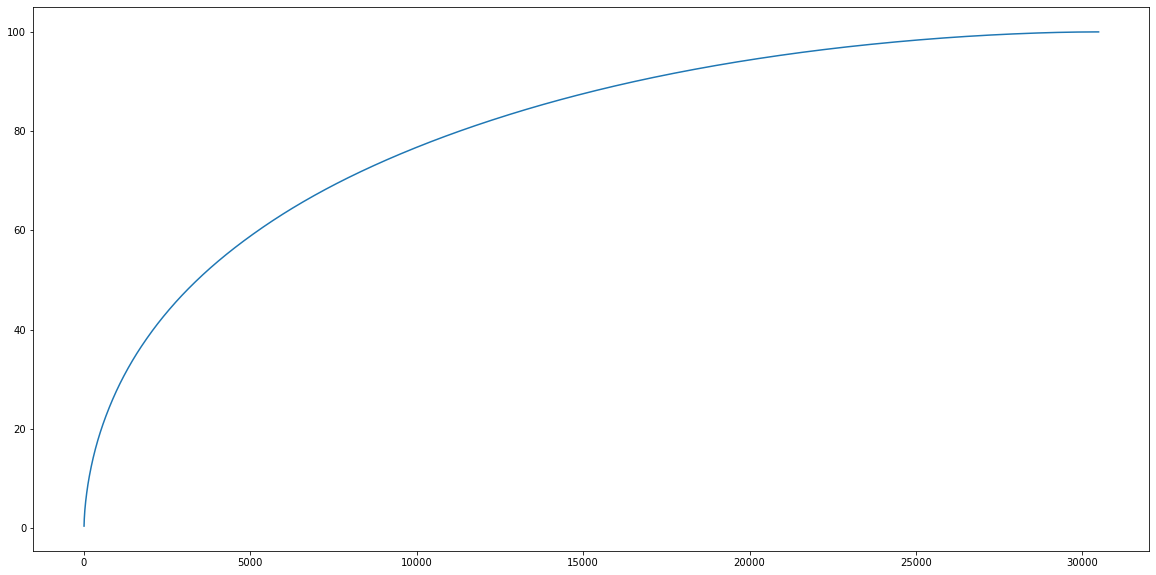

In [12]:
plt.figure(figsize=(20, 10))
plt.plot(last_year['cumul_share'])
plt.show()

In [13]:
# 1. first 20% of revenue
list_1 = last_year.loc[last_year.cumul_share <= 20]['id'].values.tolist()
print(list_1)
#last_year.loc[last_year.cumul_share <= 20]

['HOBBIES_1_354_TX_3_evaluation', 'HOBBIES_1_158_TX_3_evaluation', 'FOODS_1_096_WI_2_evaluation', 'FOODS_3_120_CA_3_evaluation', 'HOBBIES_1_354_TX_2_evaluation', 'FOODS_3_120_CA_1_evaluation', 'FOODS_3_090_CA_3_evaluation', 'HOBBIES_1_158_TX_2_evaluation', 'FOODS_3_134_WI_2_evaluation', 'FOODS_1_096_TX_3_evaluation', 'HOBBIES_1_354_CA_1_evaluation', 'FOODS_3_511_CA_1_evaluation', 'HOBBIES_1_354_CA_3_evaluation', 'FOODS_3_120_WI_3_evaluation', 'FOODS_1_096_WI_3_evaluation', 'FOODS_3_586_TX_2_evaluation', 'HOUSEHOLD_1_106_CA_3_evaluation', 'FOODS_3_202_TX_3_evaluation', 'HOBBIES_1_158_TX_1_evaluation', 'FOODS_3_120_TX_3_evaluation', 'HOUSEHOLD_1_053_CA_3_evaluation', 'FOODS_3_282_CA_3_evaluation', 'FOODS_3_202_TX_1_evaluation', 'FOODS_3_090_WI_3_evaluation', 'FOODS_3_586_CA_3_evaluation', 'FOODS_3_586_TX_3_evaluation', 'HOUSEHOLD_1_110_WI_2_evaluation', 'FOODS_3_202_CA_3_evaluation', 'HOUSEHOLD_1_032_CA_1_evaluation', 'HOBBIES_1_158_CA_3_evaluation', 'FOODS_2_056_WI_2_evaluation', 'HOBBI

In [14]:
last_year.loc[last_year.cumul_share <= 20]

,id,revenue,sales,share,cumul_share
0,HOBBIES_1_354_TX_3_evaluation,63195.000000,2750,0.412143,0.412143
1,HOBBIES_1_158_TX_3_evaluation,55014.117188,2394,0.358789,0.770933
2,FOODS_1_096_WI_2_evaluation,44252.039062,6119,0.288602,1.059534
3,FOODS_3_120_CA_3_evaluation,31636.939453,6353,0.206329,1.265863
4,HOBBIES_1_354_TX_2_evaluation,28747.980469,1251,0.187488,1.453351
...,...,...,...,...,...
516,FOODS_3_540_TX_2_evaluation,3096.219971,1039,0.020193,19.905264
517,HOUSEHOLD_1_191_CA_2_evaluation,3093.199951,1045,0.020173,19.925438
518,HOUSEHOLD_1_344_CA_3_evaluation,3092.699951,390,0.020170,19.945608
519,FOODS_2_276_WI_2_evaluation,3084.840088,902,0.020119,19.965727


In [15]:
# 2. first 40% of revenue
list_2 = last_year.loc[(last_year.cumul_share <= 40)&(last_year.cumul_share > 20)]['id'].values.tolist()
print(list_2)
#last_year.loc[(last_year.cumul_share <= 40)&(last_year.cumul_share > 20)]

['FOODS_3_393_CA_1_evaluation', 'FOODS_3_672_TX_2_evaluation', 'FOODS_3_574_CA_3_evaluation', 'HOBBIES_1_004_CA_3_evaluation', 'FOODS_3_329_WI_1_evaluation', 'FOODS_3_811_CA_3_evaluation', 'FOODS_2_347_WI_2_evaluation', 'FOODS_2_276_CA_3_evaluation', 'FOODS_3_652_TX_2_evaluation', 'HOUSEHOLD_1_140_TX_2_evaluation', 'FOODS_2_181_TX_1_evaluation', 'FOODS_3_714_CA_2_evaluation', 'FOODS_2_029_TX_2_evaluation', 'HOUSEHOLD_1_497_CA_1_evaluation', 'FOODS_3_804_CA_3_evaluation', 'FOODS_3_462_WI_2_evaluation', 'HOUSEHOLD_1_440_TX_3_evaluation', 'HOUSEHOLD_1_051_TX_2_evaluation', 'HOBBIES_1_226_CA_3_evaluation', 'HOBBIES_1_098_TX_3_evaluation', 'HOUSEHOLD_1_373_CA_3_evaluation', 'FOODS_2_318_WI_2_evaluation', 'FOODS_3_263_WI_3_evaluation', 'FOODS_3_329_TX_3_evaluation', 'FOODS_2_029_WI_3_evaluation', 'HOUSEHOLD_1_514_TX_2_evaluation', 'HOBBIES_1_226_TX_2_evaluation', 'FOODS_3_723_TX_3_evaluation', 'FOODS_3_327_WI_2_evaluation', 'HOUSEHOLD_1_488_WI_2_evaluation', 'FOODS_3_723_TX_1_evaluation', 'H

In [16]:
last_year.loc[(last_year.cumul_share <= 40)&(last_year.cumul_share > 20)]

,id,revenue,sales,share,cumul_share
521,FOODS_3_393_CA_1_evaluation,3074.679932,869,0.020052,20.005873
522,FOODS_3_672_TX_2_evaluation,3072.000000,1182,0.020035,20.025908
523,FOODS_3_574_CA_3_evaluation,3067.739990,513,0.020007,20.045914
524,HOBBIES_1_004_CA_3_evaluation,3067.039795,661,0.020003,20.065916
525,FOODS_3_329_WI_1_evaluation,3066.419922,1029,0.019998,20.085915
...,...,...,...,...,...
2073,FOODS_3_039_WI_3_evaluation,1389.020020,349,0.009059,39.963371
2074,FOODS_3_245_CA_2_evaluation,1388.800049,560,0.009057,39.972427
2075,FOODS_3_030_CA_1_evaluation,1388.239990,938,0.009054,39.981480
2076,FOODS_3_473_WI_1_evaluation,1387.759888,332,0.009051,39.990532


In [17]:
# 3. first 60% of revenue
list_3 = last_year.loc[(last_year.cumul_share <= 60)&(last_year.cumul_share > 40)]['id'].values.tolist()
print(list_3)
# last_year.loc[(last_year.cumul_share <= 60)&(last_year.cumul_share > 40)]

['HOBBIES_1_384_CA_1_evaluation', 'HOUSEHOLD_1_488_WI_1_evaluation', 'FOODS_2_334_CA_1_evaluation', 'FOODS_3_257_CA_2_evaluation', 'FOODS_3_150_WI_1_evaluation', 'FOODS_2_253_CA_3_evaluation', 'FOODS_2_198_TX_1_evaluation', 'FOODS_3_238_CA_3_evaluation', 'FOODS_3_154_TX_3_evaluation', 'FOODS_2_325_WI_2_evaluation', 'FOODS_1_187_TX_3_evaluation', 'FOODS_3_636_TX_1_evaluation', 'FOODS_3_398_CA_3_evaluation', 'FOODS_3_785_TX_3_evaluation', 'HOUSEHOLD_1_409_TX_1_evaluation', 'HOBBIES_1_225_CA_2_evaluation', 'FOODS_1_096_CA_3_evaluation', 'HOUSEHOLD_1_140_CA_4_evaluation', 'FOODS_2_380_TX_1_evaluation', 'HOUSEHOLD_2_051_CA_3_evaluation', 'FOODS_2_035_TX_2_evaluation', 'FOODS_1_082_WI_2_evaluation', 'FOODS_2_151_WI_2_evaluation', 'HOUSEHOLD_1_040_CA_1_evaluation', 'HOBBIES_1_394_CA_3_evaluation', 'HOBBIES_1_345_CA_4_evaluation', 'FOODS_3_324_CA_1_evaluation', 'HOUSEHOLD_1_221_CA_3_evaluation', 'FOODS_3_231_TX_2_evaluation', 'FOODS_2_251_TX_1_evaluation', 'FOODS_3_444_CA_2_evaluation', 'HOUSE

In [18]:
last_year.loc[(last_year.cumul_share <= 60)&(last_year.cumul_share > 40)]

,id,revenue,sales,share,cumul_share
2078,HOBBIES_1_384_CA_1_evaluation,1387.219971,139,0.009047,40.008629
2079,HOUSEHOLD_1_488_WI_1_evaluation,1387.219971,139,0.009047,40.017677
2080,FOODS_2_334_CA_1_evaluation,1387.219971,139,0.009047,40.026726
2081,FOODS_3_257_CA_2_evaluation,1386.560059,347,0.009043,40.035770
2082,FOODS_3_150_WI_1_evaluation,1385.559937,737,0.009036,40.044807
...,...,...,...,...,...
5233,FOODS_3_460_WI_2_evaluation,720.859985,372,0.004701,59.977009
5234,FOODS_1_015_CA_3_evaluation,720.359985,207,0.004698,59.981709
5235,FOODS_2_225_WI_2_evaluation,720.000000,288,0.004696,59.986404
5236,HOUSEHOLD_1_198_WI_3_evaluation,719.740051,742,0.004694,59.991096


In [19]:
# 4. first  each of revenue from [5238:1200]
list_4 = last_year[5238:12000]['id'].values.tolist()
print(list_4)
# last_year[5238:12000]

['HOUSEHOLD_1_413_WI_3_evaluation', 'HOUSEHOLD_2_110_TX_3_evaluation', 'HOBBIES_1_104_WI_1_evaluation', 'FOODS_1_043_WI_1_evaluation', 'HOBBIES_1_180_WI_1_evaluation', 'FOODS_1_063_WI_1_evaluation', 'FOODS_2_379_CA_4_evaluation', 'HOUSEHOLD_1_044_CA_1_evaluation', 'HOUSEHOLD_1_009_TX_3_evaluation', 'HOUSEHOLD_1_443_TX_2_evaluation', 'HOUSEHOLD_1_339_CA_1_evaluation', 'FOODS_3_706_CA_4_evaluation', 'FOODS_3_460_CA_1_evaluation', 'FOODS_3_460_CA_3_evaluation', 'HOBBIES_1_344_CA_4_evaluation', 'HOUSEHOLD_1_067_TX_1_evaluation', 'HOUSEHOLD_1_033_WI_1_evaluation', 'HOBBIES_1_342_WI_2_evaluation', 'FOODS_1_178_CA_1_evaluation', 'HOBBIES_1_160_WI_2_evaluation', 'FOODS_2_254_WI_2_evaluation', 'HOBBIES_1_194_WI_1_evaluation', 'HOUSEHOLD_1_439_WI_2_evaluation', 'FOODS_3_152_CA_3_evaluation', 'FOODS_3_230_WI_3_evaluation', 'HOBBIES_1_279_WI_1_evaluation', 'FOODS_3_674_WI_1_evaluation', 'FOODS_3_041_WI_1_evaluation', 'FOODS_2_240_WI_3_evaluation', 'FOODS_3_792_WI_2_evaluation', 'HOUSEHOLD_1_287_TX

In [20]:
last_year[5238:12000]

,id,revenue,sales,share,cumul_share
5238,HOUSEHOLD_1_413_WI_3_evaluation,719.699951,40,0.004694,60.000481
5239,HOUSEHOLD_2_110_TX_3_evaluation,719.590027,227,0.004693,60.005173
5240,HOBBIES_1_104_WI_1_evaluation,719.399963,30,0.004692,60.009865
5241,FOODS_1_043_WI_1_evaluation,719.320007,367,0.004691,60.014557
5242,HOBBIES_1_180_WI_1_evaluation,719.279968,36,0.004691,60.019249
...,...,...,...,...,...
11995,FOODS_2_225_CA_2_evaluation,342.500000,137,0.002234,81.646904
11996,FOODS_2_278_CA_3_evaluation,342.500000,137,0.002234,81.649139
11997,HOBBIES_1_117_CA_1_evaluation,342.360016,27,0.002233,81.651375
11998,HOUSEHOLD_1_010_CA_2_evaluation,342.360016,108,0.002233,81.653610


In [21]:
# 5. first  each of revenue from [12000:19000]
list_5 = last_year[12000:19000]['id'].values.tolist()
print(list_5)
# last_year[12000:19000]

['FOODS_3_677_TX_2_evaluation', 'HOBBIES_1_132_TX_2_evaluation', 'FOODS_3_537_TX_3_evaluation', 'FOODS_3_100_TX_3_evaluation', 'FOODS_3_294_CA_4_evaluation', 'HOUSEHOLD_1_238_WI_2_evaluation', 'HOBBIES_1_268_WI_1_evaluation', 'FOODS_2_147_CA_4_evaluation', 'FOODS_3_093_WI_3_evaluation', 'HOBBIES_1_292_TX_1_evaluation', 'HOUSEHOLD_1_225_WI_1_evaluation', 'FOODS_2_265_WI_2_evaluation', 'HOUSEHOLD_1_311_WI_3_evaluation', 'FOODS_3_370_CA_1_evaluation', 'FOODS_2_045_CA_2_evaluation', 'FOODS_2_379_TX_3_evaluation', 'FOODS_1_083_WI_1_evaluation', 'FOODS_2_327_WI_1_evaluation', 'FOODS_2_081_TX_1_evaluation', 'HOUSEHOLD_2_199_TX_2_evaluation', 'HOUSEHOLD_2_159_CA_1_evaluation', 'FOODS_3_096_WI_2_evaluation', 'HOUSEHOLD_2_015_CA_1_evaluation', 'FOODS_3_285_WI_3_evaluation', 'FOODS_3_390_CA_3_evaluation', 'FOODS_2_086_CA_4_evaluation', 'HOBBIES_1_344_TX_2_evaluation', 'HOUSEHOLD_1_455_TX_1_evaluation', 'HOUSEHOLD_2_226_CA_1_evaluation', 'HOUSEHOLD_2_126_CA_2_evaluation', 'HOUSEHOLD_1_068_TX_2_eva

In [22]:
last_year[12000:19000]

,id,revenue,sales,share,cumul_share
12000,FOODS_3_677_TX_2_evaluation,342.279999,86,0.002232,81.658081
12001,HOBBIES_1_132_TX_2_evaluation,342.279999,86,0.002232,81.660316
12002,FOODS_3_537_TX_3_evaluation,342.279999,86,0.002232,81.662552
12003,FOODS_3_100_TX_3_evaluation,342.279999,86,0.002232,81.664787
12004,FOODS_3_294_CA_4_evaluation,342.239990,138,0.002232,81.667023
...,...,...,...,...,...
18995,FOODS_1_050_TX_1_evaluation,179.399994,30,0.001170,93.239891
18996,FOODS_3_049_WI_3_evaluation,179.399994,38,0.001170,93.241058
18997,FOODS_2_127_CA_3_evaluation,179.279999,24,0.001169,93.242226
18998,FOODS_3_452_TX_1_evaluation,179.279999,36,0.001169,93.243393


In [23]:
# 6. first  each of revenue from [19000:26000]
list_6 = last_year[19000:26000]['id'].values.tolist()
print(list_6)
# last_year[19000:26000]

['FOODS_2_039_CA_2_evaluation', 'FOODS_3_527_TX_3_evaluation', 'FOODS_2_007_CA_1_evaluation', 'FOODS_3_663_CA_2_evaluation', 'FOODS_1_117_WI_3_evaluation', 'FOODS_1_195_TX_1_evaluation', 'HOBBIES_1_379_TX_2_evaluation', 'HOUSEHOLD_2_380_WI_2_evaluation', 'HOBBIES_1_418_WI_3_evaluation', 'FOODS_3_209_CA_2_evaluation', 'FOODS_3_626_WI_3_evaluation', 'HOUSEHOLD_2_175_CA_1_evaluation', 'FOODS_2_209_CA_2_evaluation', 'HOUSEHOLD_1_049_CA_3_evaluation', 'HOUSEHOLD_2_090_CA_4_evaluation', 'HOUSEHOLD_2_280_CA_2_evaluation', 'HOUSEHOLD_1_330_CA_4_evaluation', 'FOODS_2_047_TX_1_evaluation', 'HOBBIES_1_107_CA_3_evaluation', 'FOODS_2_297_CA_4_evaluation', 'HOUSEHOLD_2_207_CA_4_evaluation', 'FOODS_3_319_CA_4_evaluation', 'FOODS_3_752_CA_1_evaluation', 'FOODS_3_437_TX_3_evaluation', 'FOODS_3_024_TX_1_evaluation', 'FOODS_3_524_CA_4_evaluation', 'HOUSEHOLD_2_262_CA_4_evaluation', 'HOUSEHOLD_2_104_CA_2_evaluation', 'FOODS_3_597_WI_1_evaluation', 'FOODS_2_200_TX_1_evaluation', 'HOUSEHOLD_2_488_TX_3_evalu

In [24]:
last_year[19000:26000]

,id,revenue,sales,share,cumul_share
19000,FOODS_2_039_CA_2_evaluation,179.279999,36,0.001169,93.245728
19001,FOODS_3_527_TX_3_evaluation,179.279999,36,0.001169,93.246895
19002,FOODS_2_007_CA_1_evaluation,179.220001,61,0.001169,93.248062
19003,FOODS_3_663_CA_2_evaluation,179.220001,103,0.001169,93.249229
19004,FOODS_1_117_WI_3_evaluation,179.199997,80,0.001169,93.250397
...,...,...,...,...,...
25995,HOBBIES_1_419_TX_1_evaluation,71.760002,12,0.000468,98.855972
25996,HOUSEHOLD_2_274_TX_2_evaluation,71.760002,12,0.000468,98.856438
25997,HOUSEHOLD_1_433_WI_3_evaluation,71.760002,8,0.000468,98.856903
25998,HOBBIES_1_368_WI_3_evaluation,71.739998,17,0.000468,98.857368


In [25]:
# 7. first  each of revenue from [26000:]
list_7 = last_year[26000:]['id'].values.tolist()
print(list_7)
# last_year[26000:]

['HOBBIES_1_041_WI_2_evaluation', 'HOUSEHOLD_2_398_TX_3_evaluation', 'HOUSEHOLD_1_428_WI_3_evaluation', 'HOUSEHOLD_2_481_CA_4_evaluation', 'HOUSEHOLD_2_473_CA_4_evaluation', 'HOUSEHOLD_2_198_WI_1_evaluation', 'HOBBIES_2_072_CA_4_evaluation', 'FOODS_2_305_WI_3_evaluation', 'FOODS_1_057_CA_2_evaluation', 'HOBBIES_1_230_CA_3_evaluation', 'FOODS_3_325_TX_1_evaluation', 'FOODS_3_771_WI_3_evaluation', 'HOUSEHOLD_2_060_CA_1_evaluation', 'HOBBIES_1_114_TX_2_evaluation', 'HOUSEHOLD_2_253_TX_2_evaluation', 'HOUSEHOLD_2_060_CA_2_evaluation', 'HOUSEHOLD_2_090_WI_1_evaluation', 'FOODS_3_255_TX_1_evaluation', 'HOUSEHOLD_2_387_WI_3_evaluation', 'HOUSEHOLD_2_387_WI_2_evaluation', 'HOUSEHOLD_2_175_TX_1_evaluation', 'HOBBIES_1_162_CA_1_evaluation', 'FOODS_3_626_TX_2_evaluation', 'HOUSEHOLD_2_138_WI_3_evaluation', 'HOUSEHOLD_2_253_CA_3_evaluation', 'FOODS_2_284_CA_1_evaluation', 'HOBBIES_2_120_CA_4_evaluation', 'HOBBIES_1_107_CA_2_evaluation', 'HOBBIES_2_045_CA_3_evaluation', 'HOBBIES_2_024_CA_4_evaluati

In [26]:
last_year[26000:]

,id,revenue,sales,share,cumul_share
26000,HOBBIES_1_041_WI_2_evaluation,71.739998,17,0.000468,98.858299
26001,HOUSEHOLD_2_398_TX_3_evaluation,71.729996,9,0.000468,98.858765
26002,HOUSEHOLD_1_428_WI_3_evaluation,71.729996,9,0.000468,98.859230
26003,HOUSEHOLD_2_481_CA_4_evaluation,71.729996,9,0.000468,98.859695
26004,HOUSEHOLD_2_473_CA_4_evaluation,71.729996,9,0.000468,98.860161
...,...,...,...,...,...
30485,HOUSEHOLD_2_108_TX_3_evaluation,0.000000,0,0.000000,99.999657
30486,HOUSEHOLD_2_108_WI_3_evaluation,0.000000,0,0.000000,99.999657
30487,FOODS_3_369_WI_2_evaluation,0.000000,0,0.000000,99.999657
30488,HOUSEHOLD_2_147_TX_1_evaluation,0.000000,0,0.000000,99.999657


In [27]:
# last_year.loc[last_year.sales==0]

## check if all id-s in the list


In [28]:
# check if all id-s in the list
len(list_1+list_2+list_3+list_4+list_5+list_6+list_7) == df.id.nunique()
   

True

In [29]:
(list_1+list_2+list_3+list_4+list_5+list_6+list_7).sort() == df.id.unique().tolist().sort()

True

## Get df from list_1 to list_7

In [30]:
#make df_1
df_1 = df.loc[df['id'].isin(list_1)]
df_1.set_index('date',inplace=True)
df_1.sort_values(by='date',inplace=True)

del df_1['revenue']
df_1.to_pickle('df_1.pkl')

In [31]:
#make df_2
df_2 = df.loc[df['id'].isin(list_2)]
df_2.set_index('date',inplace=True)
df_2.sort_values(by='date',inplace=True)

del df_2['revenue']
df_2.to_pickle('df_2.pkl')

In [32]:
#make df_3
df_3 = df.loc[df['id'].isin(list_3)]
df_3.set_index('date',inplace=True)
df_3.sort_values(by='date',inplace=True)

del df_3['revenue']
df_3.to_pickle('df_3.pkl')

In [33]:
#make df_4
df_4 = df.loc[df['id'].isin(list_4)]
df_4.set_index('date',inplace=True)
df_4.sort_values(by='date',inplace=True)

del df_4['revenue']
df_4.to_pickle('df_4.pkl')

In [34]:
#make df_5
df_5 = df.loc[df['id'].isin(list_5)]
df_5.set_index('date',inplace=True)
df_5.sort_values(by='date',inplace=True)

del df_5['revenue']
df_5.to_pickle('df_5.pkl')

In [35]:
#make df_6
df_6 = df.loc[df['id'].isin(list_6)]
df_6.set_index('date',inplace=True)
df_6.sort_values(by='date',inplace=True)

del df_6['revenue']
df_6.to_pickle('df_6.pkl')

In [36]:
#make df_7
df_7 = df.loc[df['id'].isin(list_7)]
df_7.set_index('date',inplace=True)
df_7.sort_values(by='date',inplace=True)

del df_7['revenue']
df_7.to_pickle('df_7.pkl')

## Get top_200

In [37]:
# top_200 = df.groupby(by=df['id'])[['revenue']].mean().sort_values(by = 'revenue',ascending=False)[:200]
# top_200.reset_index(inplace=True)
# top_200 = top_200.id.unique().tolist()

# #make top_200 df
# df_200 = df.loc[df['id'].isin(top_200)]
# df_200.set_index('date',inplace=True)
# df_200.sort_values(by='date',inplace=True)

# del top_200
# del df_200['revenue']

# df_200.to_pickle('df_200.pkl')

## Get final df**

In [38]:
# del df['revenue']
# df.set_index('date',inplace=True)
# df.sort_values(by='date',inplace=True)
# df.info()

In [39]:
#df.to_pickle('wm_sales.pkl')

## Get final df splitted by state and by store

## 1. DF - TX by state

In [40]:
# df_tx = df.loc[df.state_id == 'TX']
# df_tx.sort_values(by='date',inplace=True)

In [41]:
# df_tx.info()

In [42]:
# df_tx.to_pickle('df_tx.pkl')

## df_CA1

In [43]:
# df_ca_1 = df.loc[df.store_id == 'CA_1']
# df_ca_1.sort_values(by='date',inplace=True)
# df_ca_1.to_pickle('df_ca_1.pkl')

In [44]:
# df_ca_1